In [ ]:
import math
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

# Utilities

In [108]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
def adf_test(df, response, alpha=0.05, autolag='AIC'):
    series = pd.to_numeric(df[response], errors='coerce').dropna()

    _, pval, _, _, _, _ = adfuller(series, autolag=autolag)

    is_stationary = pval < alpha

    if is_stationary:
        reason = (f'Stationary: ADF p-value={pval:.4g} < {alpha} so reject the null hypothesis')
    else:
        reason = (f'Non-stationary: ADF p-value={pval:.4g} >= {alpha} so fail to reject the null hypothesis')

    return reason

In [109]:
# For reproducability
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Datasets

## AMD

In [110]:
df_amd = pd.read_csv('data/AMD.csv', parse_dates=['Date'], index_col='Date')
print(df_amd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10098 non-null  float64
 1   High       10098 non-null  float64
 2   Low        10098 non-null  float64
 3   Close      10098 non-null  float64
 4   Adj Close  10098 non-null  float64
 5   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.2 KB
None


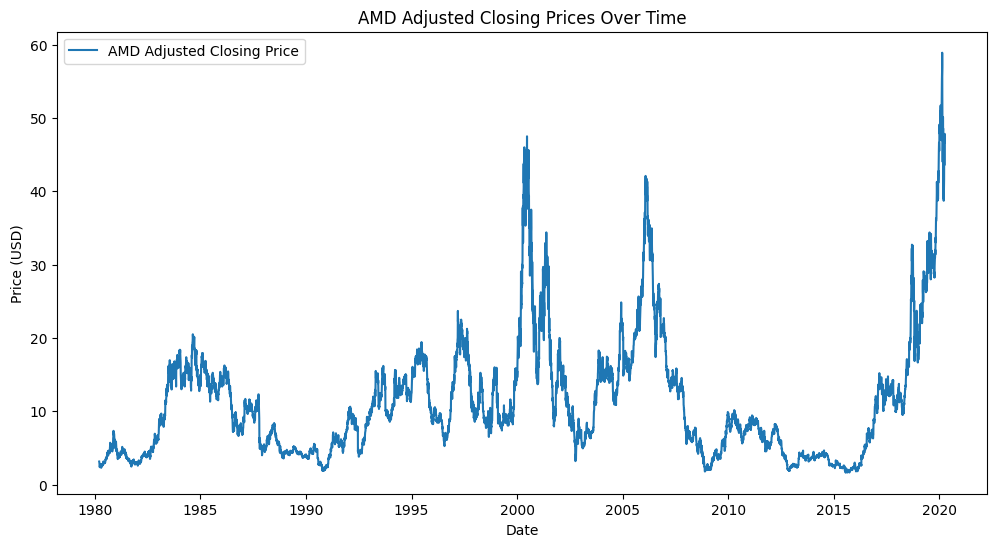

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(df_amd['Adj Close'], label='AMD Adjusted Closing Price')
plt.title('AMD Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [112]:
print(adf_test(df_amd, 'Adj Close'))

Non-stationary: ADF p-value=0.05468 >= 0.05 so fail to reject the null hypothesis


In [113]:
df_amd = df_amd.drop(columns=['Close'])
df_amd = df_amd[df_amd['Open'] != 0.0]

X_amd = df_amd[['Open', 'High', 'Low', 'Volume']].values
y_amd = df_amd['Adj Close'].values.reshape(-1, 1)

scaler_X_amd = MinMaxScaler() # best for tanh activations, avoiding exploding values
scaler_y_amd = MinMaxScaler()

X_scaled_amd = scaler_X_amd.fit_transform(X_amd)
y_scaled_amd = scaler_y_amd.fit_transform(y_amd)

## Air Quality

In [114]:
df_air = pd.read_csv('data/AirQualityUCI.csv', sep=';', decimal=',', na_values=[-200, '-200'])
df_air = df_air.loc[:, ~df_air.columns.str.contains("^Unnamed")]
print(df_air.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB
None


In [115]:
ts = pd.to_datetime(
    df_air['Date'].astype(str).str.strip() + ' ' + df_air['Time'].astype(str).str.replace('.', ':', regex=False),
    dayfirst=True,
    errors='coerce'
)

df_air.insert(0, 'timestamp', ts)
df_air = df_air.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True) # drop bad timestamps
df_air = df_air.set_index('timestamp').sort_index()

df_air = df_air.drop(columns=['Date', 'Time'])

In [116]:
df_air.dropna(subset='CO(GT)')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
timestamp,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


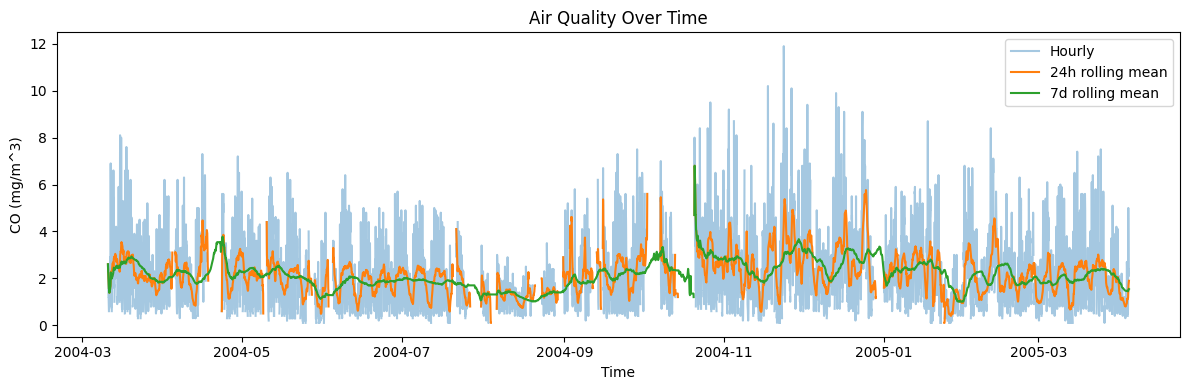

In [117]:
df_air['CO_24h_mean'] = df_air['CO(GT)'].rolling(24, min_periods=1).mean()
df_air['CO_7d_mean']  = df_air['CO(GT)'].rolling(24*7, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_air.index, df_air['CO(GT)'], alpha=0.4, label='Hourly')
plt.plot(df_air.index, df_air['CO_24h_mean'], label='24h rolling mean')
plt.plot(df_air.index, df_air['CO_7d_mean'], label='7d rolling mean')
plt.title('Air Quality Over Time')
plt.xlabel('Time')
plt.ylabel('CO (mg/m^3)')
plt.legend()
plt.tight_layout()
# plt.savefig('air_q_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [118]:
print(adf_test(df_air, 'CO(GT)'))

Stationary: ADF p-value=2.498e-16 < 0.05 so reject the null hypothesis


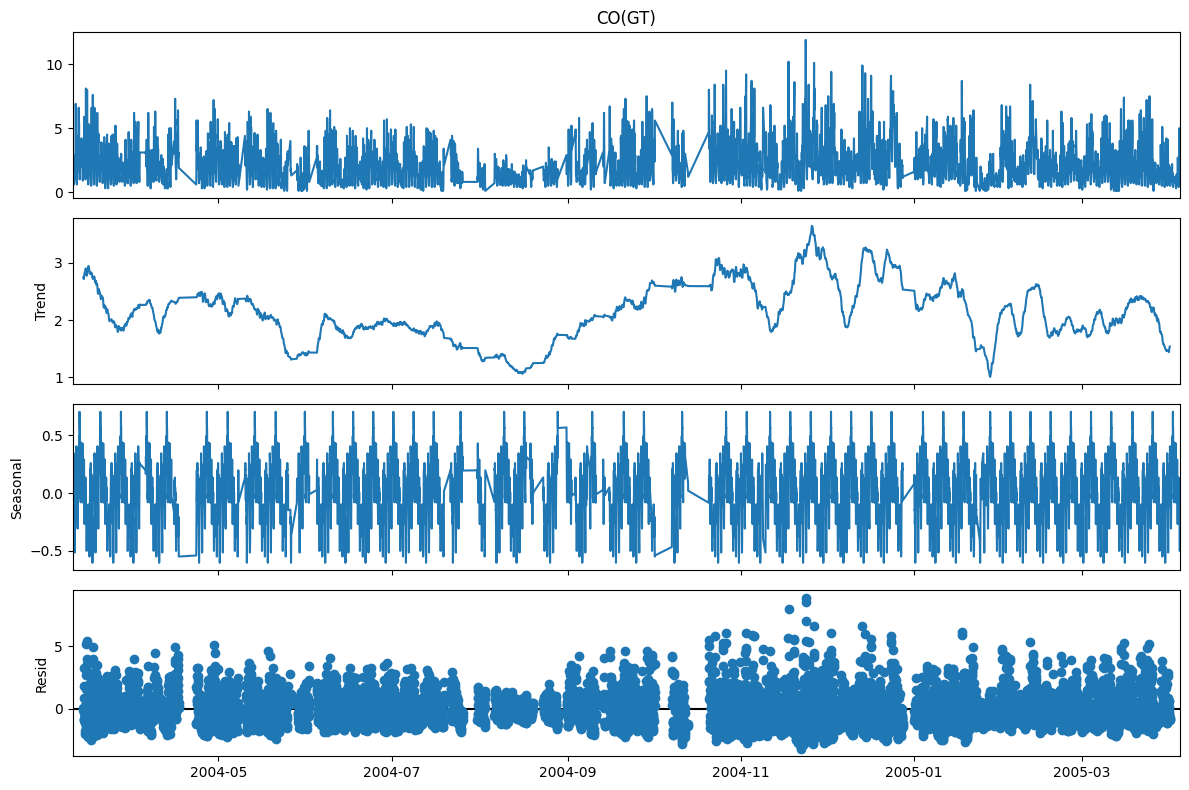

In [ ]:
decomposition = seasonal_decompose(df_air['CO(GT)'].dropna(), model='additive', period=24*7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
#plt.savefig('air_q_seasonal.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [120]:
df_air = df_air.drop(columns=['CO_24h_mean', 'CO_7d_mean'])
df_air = df_air.dropna(subset=['CO(GT)'].copy())

In [121]:
sensor_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
met_cols    = ['T', 'RH', 'AH']

# Missing value co-location check
block_cols = sensor_cols + met_cols
co_missing_mask = df_air[block_cols].isna().all(axis=1)
n_co_missing = int(co_missing_mask.sum())

if n_co_missing > 0:
    df_air = df_air.loc[~co_missing_mask].copy()

df_air = df_air.sort_index()
df_air = df_air.interpolate(method='time', limit_direction='both')
df_air = df_air.ffill().bfill()

feat_cols = sensor_cols + met_cols
response_col = 'CO(GT)'

X_air = df_air[feat_cols].values
y_air = df_air[[response_col]].values

scaler_X_air = MinMaxScaler() # Again best for tanh activation functions
scaler_y_air = MinMaxScaler()

X_scaled_air = scaler_X_air.fit_transform(X_air)
y_scaled_air = scaler_y_air.fit_transform(y_air)

## Garment Productivity

In [122]:
df_prod = pd.read_csv('data/garments_worker_productivity.csv')
df_prod.columns = [c.strip().lower() for c in df_prod.columns]

df_prod['department'] = (
    df_prod['department']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({'sweing': 'sewing', 'finishing ': 'finishing'})
)

df_prod['date'] = pd.to_datetime(df_prod['date'], dayfirst=False, errors='coerce')
df_prod = df_prod.dropna(subset=['date', 'actual_productivity']).copy()

df_prod = df_prod.sort_values('date').set_index('date')

print(df_prod.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1197 entries, 2015-01-01 to 2015-03-11
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
mem

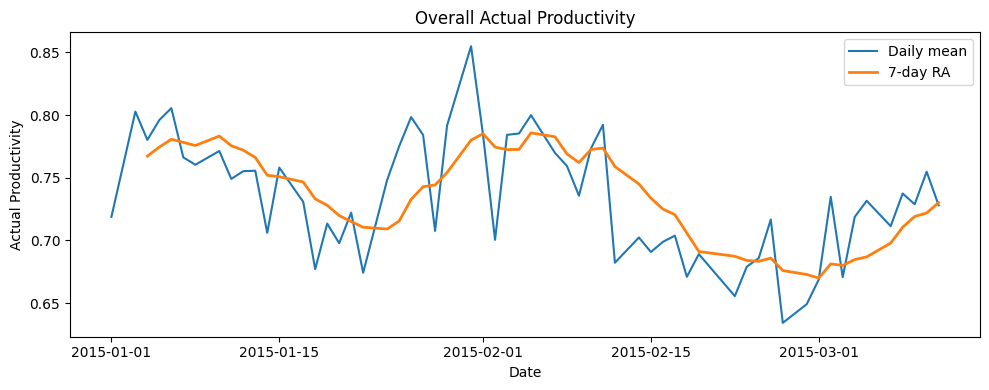

In [123]:
overall = (
    df_prod
    .groupby(pd.Grouper(freq='D'))['actual_productivity']
    .mean()
    .dropna()
)

overall_smooth = overall.rolling(window=7, min_periods=3).mean()

plt.figure(figsize=(10, 4))
plt.plot(overall.index, overall.values, label='Daily mean')
plt.plot(overall_smooth.index, overall_smooth.values, label='7-day RA', linewidth=2)
plt.title('Overall Actual Productivity')
plt.xlabel('Date')
plt.ylabel('Actual Productivity')
plt.legend()
plt.tight_layout()
# plt.savefig('actual_prod.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [124]:
print(adf_test(df_prod, 'actual_productivity'))

Stationary: ADF p-value=0.001457 < 0.05 so reject the null hypothesis


In [125]:
df_prod = df_prod.drop(columns=['wip'])

In [126]:
num_cols = ['targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
cat_cols = ['quarter', 'department', 'day', 'team']

X_num = df_prod[num_cols].astype(float)
X_cat = pd.get_dummies(df_prod[cat_cols], drop_first=False)

X_prod = pd.concat([X_num, X_cat], axis=1).astype(float)
y_prod = df_prod['actual_productivity'].values.reshape(-1, 1)

scaler_X_prod = MinMaxScaler()
scaler_y_prod = MinMaxScaler()

X_scaled_prod = scaler_X_prod.fit_transform(X_prod)
y_scaled_prod = scaler_y_prod.fit_transform(y_prod)

## Electric Production

In [158]:
df_ep = pd.read_csv('data/Electric_Production.csv', parse_dates=['DATE'], index_col='DATE')
print(df_ep.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB
None


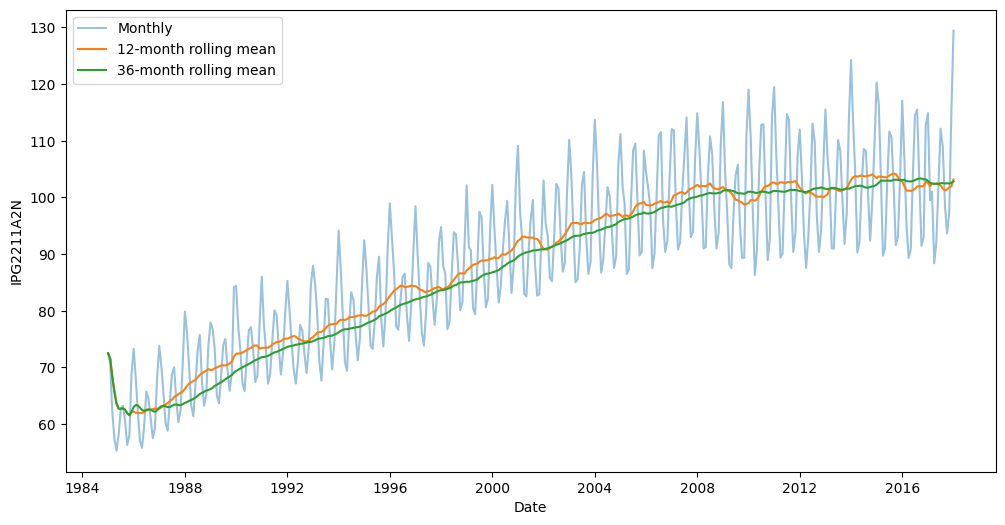

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_ep.index, df_ep['IPG2211A2N'], alpha=0.45, label='Monthly')
plt.plot(df_ep.index, df_ep['IPG2211A2N'].rolling(window=12, min_periods=1).mean(),  label='12-month rolling mean')
plt.plot(df_ep.index, df_ep['IPG2211A2N'].rolling(window=36, min_periods=1).mean(),  label='36-month rolling mean')
plt.title('Electric Production Over Time')
plt.xlabel('Date')
plt.ylabel('IPG2211A2N')
plt.legend()
# plt.savefig('ep_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [160]:
print(adf_test(df_ep, 'IPG2211A2N'))

Non-stationary: ADF p-value=0.1862 >= 0.05 so fail to reject the null hypothesis


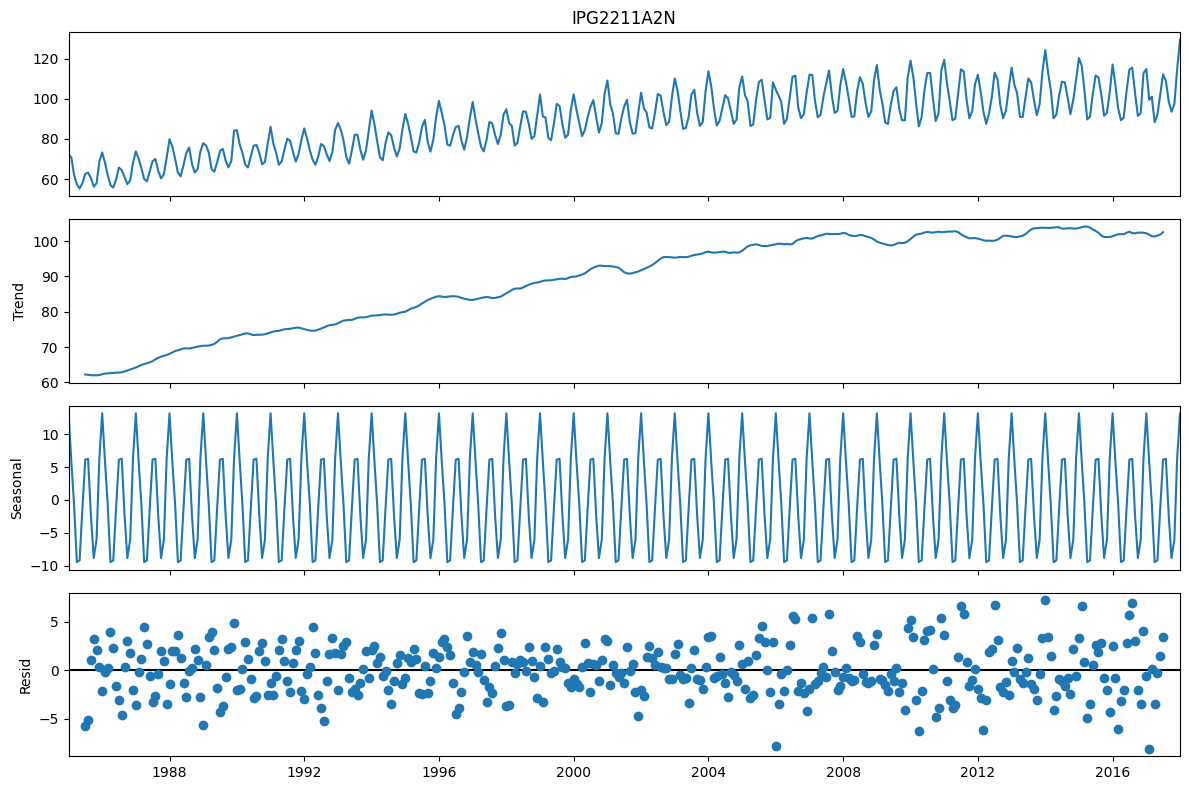

In [ ]:
decomposition = seasonal_decompose(df_ep['IPG2211A2N'].dropna(), model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
# plt.savefig('ep_seasonal.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [162]:
X_ep = df_ep[['IPG2211A2N']].values
y_ep = df_ep[['IPG2211A2N']].values

scaler_X_ep = MinMaxScaler()
scaler_y_ep = MinMaxScaler()

X_scaled_ep = scaler_X_ep.fit_transform(X_ep)
y_scaled_ep = scaler_y_ep.fit_transform(y_ep)

## Weather

In [130]:
df_weather = pd.read_csv('data/weather.csv', parse_dates=['date'], index_col='date')
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52696 entries, 2020-01-01 00:10:00 to 2021-01-01 00:00:00
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p         52696 non-null  float64
 1   T         52696 non-null  float64
 2   Tpot      52696 non-null  float64
 3   Tdew      52696 non-null  float64
 4   rh        52696 non-null  float64
 5   VPmax     52696 non-null  float64
 6   VPact     52696 non-null  float64
 7   VPdef     52696 non-null  float64
 8   sh        52696 non-null  float64
 9   H2OC      52696 non-null  float64
 10  rho       52696 non-null  float64
 11  wv        52696 non-null  float64
 12  max. wv   52696 non-null  float64
 13  wd        52696 non-null  float64
 14  rain      52696 non-null  float64
 15  raining   52696 non-null  float64
 16  SWDR      52696 non-null  float64
 17  PAR       52696 non-null  float64
 18  max. PAR  52696 non-null  float64
 19  Tlog      52696 non-null  float6

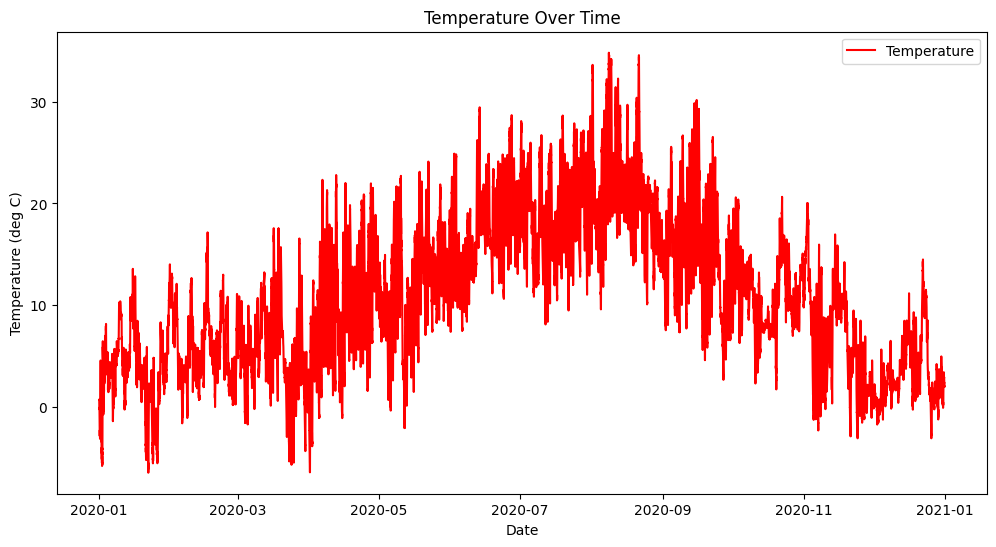

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(df_weather['T'], label='Temperature', color='red')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (deg C)')
plt.legend()
# plt.savefig('temp_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [132]:
print(adf_test(df_weather, 'T'))

Stationary: ADF p-value=2.149e-13 < 0.05 so reject the null hypothesis


In [ ]:
# df_weather = df_weather.sort_index()

# # Take first 10% of entries as it takes way to long to train on all data
# n = int(len(df_weather) * 0.10)
# df_weather = df_weather.iloc[:n].copy()

feat_cols = ['p', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR', 'max. PAR', 'Tlog']
response_col = 'T'

X_weather = df_weather[feat_cols].values
y_weather = df_weather[[response_col]].values

scaler_X_weather = MinMaxScaler()
scaler_y_weather = MinMaxScaler()

X_scaled_weather = scaler_X_weather.fit_transform(X_weather)
y_scaled_weather = scaler_y_weather.fit_transform(y_weather)

# RNNs

## Elman

In [134]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences):
        super().__init__()
        self.hidden_size = hidden_size
        self.return_sequences = return_sequences # sequence-to-one vs sequence-to-sequence

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = x.new_zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)

        if self.return_sequences:
           return self.fc(out)
        else:
            return self.fc(out[:, -1, :])

## Jordan

In [135]:
class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences, output_activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.return_sequences = return_sequences
        self.output_activation = output_activation # identity, sigmoid, softmax, tanh

        self.xh = nn.Linear(input_size, hidden_size, bias=True)
        self.yh = nn.Linear(output_size, hidden_size, bias=False)
        self.hy = nn.Linear(hidden_size, output_size, bias=True)
    
    def _activate(self, y):
        if self.output_activation == 'identity':
            return y
        
        if self.output_activation == 'sigmoid':
            return torch.sigmoid(y)
        
        if self.output_activation == 'softmax':
            return nn.functional.softmax(y, dim=-1)
        
        if self.output_activation == 'tanh':
            return torch.tanh(y)
        
    def forward(self, x):
        B, T, _ = x.shape

        y_prev = torch.zeros(B, self.output_size, device=x.device, dtype=x.dtype)
        y_prev_act = self._activate(y_prev)
        ys = []

        for t in range(T):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.xh(x_t) + self.yh(y_prev_act))
            y_t = self.hy(h_t)
            ys.append(y_t)
            y_prev_act = self._activate(y_t) # update
        
        y_seq = torch.stack(ys, dim=1)
        
        if self.return_sequences:
            return y_seq
        else:
            return y_seq[:, -1, :]

## Multi-RNN

In [136]:
# FOllows same pattern as above
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences, output_activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.return_sequences = return_sequences
        self.output_activation = output_activation

        self.xh = nn.Linear(input_size, hidden_size, bias=True)
        self.hh = nn.Linear(hidden_size, hidden_size, bias=False) # Elman Part
        self.yh = nn.Linear(output_size, hidden_size, bias=False) # Jordan Part
        self.hy = nn.Linear(hidden_size, output_size, bias=True)

    def _activate(self, y):
        if self.output_activation == 'identity':
            return y
        
        if self.output_activation == 'sigmoid':
            return torch.sigmoid(y)
        
        if self.output_activation == 'softmax':
            return nn.functional.softmax(y, dim=-1)
        
        if self.output_activation == 'tanh':
            return torch.tanh(y)
        
    def forward(self, x):
        B, T, _ = x.shape

        h_prev = torch.zeros(B, self.hidden_size, device=x.device, dtype=x.dtype)
        y_prev = torch.zeros(B, self.output_size, device=x.device, dtype=x.dtype)
        y_prev_act = self._activate(y_prev)

        ys = []
        for t in range(T):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.xh(x_t) + self.hh(h_prev) + self.yh(y_prev_act))
            y_t = self.hy(h_t)
            ys.append(y_t)

            # update recurrences
            h_prev = h_t
            y_prev_act = self._activate(y_t)

        y_seq = torch.stack(ys, dim=1)
        
        if self.return_sequences:
            return y_seq
        else:
            return y_seq[:, -1, :]

# Model Training

## Utilities

In [137]:
def make_sequences(X, y, seq_len, horizon, stride):
    N = len(X)
    out = []
    tgt = []

    last_start = N - (seq_len + horizon) + 1

    if last_start <= 0:
        raise ValueError('Not enough data for given seq_len/horizon.')
    
    for start in range(0, last_start, stride):
        end = start + seq_len
        x_seq = X[start:end]
        y_t = y[end + horizon - 1]
        out.append(x_seq)
        tgt.append(y_t)
    
    X_seq = np.stack(out, axis=0)
    y_seq = np.stack(tgt, axis=0)

    return X_seq, y_seq

In [138]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X_seq, y_seq, dtype=torch.float32):
        self.X = torch.tensor(X_seq, dtype=dtype)
        self.y = torch.tensor(y_seq, dtype=dtype)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [139]:
def rolling_windows(n_seq, train_size, val_size, step):
    if step is None:
        step = val_size

    windows = []
    i = 0

    while True:
        tr_start = i
        tr_end = i + train_size
        val_end = tr_end + val_size

        if val_end > n_seq:
            break

        windows.append((slice(tr_start, tr_end), slice(tr_end, val_end)))
        i += step

    if not windows:
        raise ValueError('No rolling windows can be formed with given sizes.')
    
    return windows

In [140]:
# "Model Factory"
def create_model(name, input_size, hidden_size, output_size, return_sequences, output_activation, device):
    if name == 'elman':
        model = ElmanRNN(input_size, hidden_size, output_size, return_sequences)
    elif name == 'jordan':
        model = JordanRNN(input_size, hidden_size, output_size, return_sequences, output_activation)
    elif name =='multi':
        model = MultiRNN(input_size, hidden_size, output_size, return_sequences, output_activation)

    if device is not None:
        model = model.to(device)
    
    return model

In [141]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)

        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()

        # Gradient clipping to ensure stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * len(xb)
        
    return total_loss / len(loader.dataset)

In [142]:
@torch.no_grad()
def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        preds = model(xb)
        loss = criterion(preds, yb)
        total_loss += loss.item() * len(xb)
        
    return total_loss / len(loader.dataset)

In [143]:
from dataclasses import dataclass

# Hold outcome of a model trainig run
@dataclass
class FitResult:
    best_state_dict: dict # snapshot of params
    best_val_loss: float
    train_losses: list
    val_losses: list

In [144]:
def fit_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience):
    best_val = math.inf
    best_state = None
    train_hist = []
    val_hist = []
    epoch_no_improve = 0

    for _ in range(epochs):
        tr = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val = evaluate_one_epoch(model, val_loader, criterion, device)
        
        train_hist.append(tr)
        val_hist.append(val)

        if val < best_val:
            best_val = val
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epoch_no_improve = 0
        else:
            epoch_no_improve += 1

            if epoch_no_improve >= patience:
                break # early stop
    
    return FitResult(best_state, best_val, train_hist, val_hist)

In [145]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    preds_all = []

    for xb, _ in loader:
        xb = xb.to(device)
        out = model(xb).detach().cpu().numpy()
        preds_all.append(out)
        
    return np.vstack(preds_all)

In [146]:
def ts_cv_score(X_seq, y_seq, windows, model_builder, criterion, eval_metric, device, batch_size, epochs, patience, lr, weight_decay):
    fold_scores = []

    for _, (tr_idx, val_idx) in enumerate(windows):
        ds_tr = TimeSeriesDataset(X_seq[tr_idx], y_seq[tr_idx])
        ds_val = TimeSeriesDataset(X_seq[val_idx], y_seq[val_idx])

        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=False, drop_last=False)
        dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, drop_last=False)

        model = model_builder()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        fit_result = fit_early_stopping(model, dl_tr, dl_val, criterion=criterion, optimizer=optimizer, device=device, epochs=epochs, patience=patience)
        model.load_state_dict(fit_result.best_state_dict)

        preds = predict_all(model, dl_val, device=device)
        y_true = ds_val.y.numpy()

        score = eval_metric(y_true, preds)
        fold_scores.append(score)

    return {
        'fold_scores': fold_scores,
        'mean_score': float(np.mean(fold_scores)),
        'std_score': float(np.std(fold_scores))
    }

In [147]:
def grid_search_ts_cv(model_name, X_seq, y_seq, windows, param_grid, device, criterion, eval_metric):
    results = []
    input_size = X_seq.shape[-1]
    output_size = y_seq.shape[-1]

    for hp in param_grid:
        def builder():
            return create_model(
                model_name,
                input_size=input_size,
                hidden_size=hp['hidden_size'],
                output_size=output_size,
                return_sequences=False,
                output_activation=hp.get('output_activation', 'identity'),
                device=device
            )

        scores = ts_cv_score(
            X_seq, y_seq,
            windows=windows,
            model_builder=builder,
            criterion=criterion,
            eval_metric=eval_metric,
            device=device,
            batch_size=hp['batch_size'],
            epochs=hp['epochs'],
            patience=hp['patience'],
            lr=hp['lr'],
            weight_decay=hp['weight_decay']
        )

        results.append({'spec': {'model_name': model_name, **hp}, 'cv': scores})

    best = min(results, key=lambda r: r['cv']['mean_score'])
    return {'best': best, 'all_results': results}

In [148]:
def fit_best(best_spec, X_train_seq, y_train_seq, X_test_seq, y_test_seq, device, criterion, metrics):
    # Build a validation set from the train set
    n_total = len(X_train_seq)
    n_val = max(1, min(n_total - 1, int(np.ceil(0.1 * n_total))))
    
    X_tr, y_tr = X_train_seq[:-n_val], y_train_seq[:-n_val]
    X_val, y_val = X_train_seq[-n_val:], y_train_seq[-n_val:]
    
    input_size = X_train_seq.shape[-1]
    output_size = y_train_seq.shape[-1]

    model = create_model(
        best_spec['model_name'],
        input_size=input_size,
        hidden_size=best_spec['hidden_size'],
        output_size=output_size,
        return_sequences=False,
        output_activation=best_spec.get('output_activation', 'identity'),
        device=device
    )

    ds_tr  = TimeSeriesDataset(X_tr,  y_tr)
    ds_val = TimeSeriesDataset(X_val, y_val)
    ds_te  = TimeSeriesDataset(X_test_seq, y_test_seq)

    dl_tr  = DataLoader(ds_tr,  batch_size=best_spec['batch_size'], shuffle=False)
    dl_val = DataLoader(ds_val, batch_size=best_spec['batch_size'], shuffle=False)
    dl_te  = DataLoader(ds_te,  batch_size=best_spec['batch_size'], shuffle=False)

    opt = torch.optim.Adam(model.parameters(), lr=best_spec['lr'], weight_decay=best_spec['weight_decay'])
    fit_result = fit_early_stopping(model, dl_tr, dl_val, criterion=criterion, optimizer=opt, device=device, epochs=best_spec['epochs'], patience=best_spec['patience'])

    model.load_state_dict(fit_result.best_state_dict)

    preds_scaled = predict_all(model, dl_te, device=device)
    y_true_scaled = ds_te.y.numpy()

    preds, y_true = preds_scaled, y_true_scaled

    out = {'preds': preds, 'y_true': y_true}

    for name, fn in metrics.items():
        out[name] = float(fn(y_true, preds))
        
    return out

In [164]:
# This is for sequence-to-one and sequence-to-sequence evaluation
def run_experiments(X_scaled, y_scaled, horizons, model_names, param_grid, device, criterion, metrics, eval_metric, seq_len, stride, test_frac):
    results = {}

    for h in horizons:
        X_seq, y_seq = make_sequences(X_scaled, y_scaled, seq_len=seq_len, horizon=h, stride=stride)

        n_seq = len(X_seq)
        test_cut = int(n_seq * test_frac)
        X_train, X_test = X_seq[:test_cut], X_seq[test_cut:]
        y_train, y_test = y_seq[:test_cut], y_seq[test_cut:]

        train_size = int(len(X_train) * 0.7)
        val_size = int(len(X_train) * 0.15)
        step = val_size
        windows = rolling_windows(len(X_train), train_size, val_size, step)

        results[h] = {}
        
        for model in model_names:
            cv = grid_search_ts_cv(model, X_train, y_train, windows, param_grid, device, criterion, eval_metric)
            
            best_spec = cv['best']['spec']
            cv_mean = cv['best']['cv']['mean_score']

            test_res = fit_best(best_spec, X_train, y_train, X_test, y_test, device, criterion, metrics)

            results[h][model] = {
                'best_spec': best_spec,
                'cv_metric_name': getattr(eval_metric, '__name__', 'CV'), # print nice
                'cv_mean': cv_mean,
                **{k: test_res[k] for k in metrics.keys()}
            }

    return results

In [165]:
def print_results(result_dict):
    for h in sorted(result_dict.keys()):
        print(f"Horizon: {h}")

        for model, rec in result_dict[h].items():
            test_parts = [f"{k}={rec[k]:.4f}" for k in rec if k not in ("best_spec", "cv_mean", "cv_metric_name")]
            print(f"{model.title()}:  CV {rec['cv_metric_name']}: {rec['cv_mean']:.4f} | Test " + ", ".join(test_parts))

        print()

## Training

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

In [152]:
def RMSE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return math.sqrt(np.mean((y_true - y_pred) ** 2))

def MAE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def R2(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    ss_res = np.sum((y_true - y_pred) ** 2)
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)

    if np.isclose(ss_tot, 0.0):
        return 1.0 if np.isclose(ss_res, 0.0) else 0.0

    return 1.0 - (ss_res / ss_tot)

In [153]:
# Hyperparameter grid
param_grid = [
    {'hidden_size': 32,  'lr': 1e-3,  'batch_size': 256, 'epochs': 60,  'patience': 8,  'weight_decay': 0.0,   'output_activation': 'identity'},
    {'hidden_size': 32,  'lr': 5e-4,  'batch_size': 512, 'epochs': 80,  'patience': 10, 'weight_decay': 1e-6,  'output_activation': 'identity'},
    {'hidden_size': 48,  'lr': 2e-4,  'batch_size': 256, 'epochs': 90,  'patience': 10, 'weight_decay': 1e-5,  'output_activation': 'identity'},
    {'hidden_size': 64,  'lr': 1e-3,  'batch_size': 256, 'epochs': 60,  'patience': 8,  'weight_decay': 1e-6,  'output_activation': 'identity'},
    {'hidden_size': 64,  'lr': 5e-4,  'batch_size': 512, 'epochs': 80,  'patience': 10, 'weight_decay': 1e-5,  'output_activation': 'identity'},
    {'hidden_size': 96,  'lr': 2e-4,  'batch_size': 256, 'epochs': 100, 'patience': 12, 'weight_decay': 0.0,   'output_activation': 'identity'},
    {'hidden_size': 128, 'lr': 1e-3,  'batch_size': 256, 'epochs': 70,  'patience': 8,  'weight_decay': 1e-5,  'output_activation': 'identity'},
    {'hidden_size': 128, 'lr': 3e-4,  'batch_size': 512, 'epochs': 100, 'patience': 12, 'weight_decay': 1e-6,  'output_activation': 'identity'},
    {'hidden_size': 160, 'lr': 2e-4,  'batch_size': 256, 'epochs': 110, 'patience': 12, 'weight_decay': 1e-5,  'output_activation': 'identity'},
    {'hidden_size': 192, 'lr': 1e-4,  'batch_size': 512, 'epochs': 120, 'patience': 12, 'weight_decay': 1e-5,  'output_activation': 'identity'},
    {'hidden_size': 224, 'lr': 7e-5,  'batch_size': 256, 'epochs': 120, 'patience': 12, 'weight_decay': 1e-4,  'output_activation': 'identity'},
    {'hidden_size': 256, 'lr': 5e-5,  'batch_size': 512, 'epochs': 120, 'patience': 12, 'weight_decay': 1e-5,  'output_activation': 'identity'},
]

In [ ]:
criterion = nn.MSELoss()
metrics = {'RMSE': RMSE, 'MAE': MAE, 'R2': R2}

### AMD Stock Data

In [ ]:
results_amd = run_experiments(X_scaled_amd, y_scaled_amd, (1, 3, 5, 7), ('elman', 'jordan', 'multi'), param_grid, device, criterion, metrics, RMSE, 30, 1, 0.8)
print_results(results_amd)





Horizon: 1
Elman:  CV RMSE: 0.0098 | Test RMSE=0.0213, MAE=0.0111, R2=0.9896
Jordan:  CV RMSE: 0.0100 | Test RMSE=0.0339, MAE=0.0159, R2=0.9737
Multi:  CV RMSE: 0.0087 | Test RMSE=0.0174, MAE=0.0103, R2=0.9931

Horizon: 3
Elman:  CV RMSE: 0.0138 | Test RMSE=0.0202, MAE=0.0106, R2=0.9907
Jordan:  CV RMSE: 0.0137 | Test RMSE=0.0226, MAE=0.0120, R2=0.9883
Multi:  CV RMSE: 0.0129 | Test RMSE=0.0208, MAE=0.0111, R2=0.9901

Horizon: 5
Elman:  CV RMSE: 0.0174 | Test RMSE=0.0269, MAE=0.0144, R2=0.9834
Jordan:  CV RMSE: 0.0166 | Test RMSE=0.0287, MAE=0.0156, R2=0.9811
Multi:  CV RMSE: 0.0166 | Test RMSE=0.0276, MAE=0.0160, R2=0.9826

Horizon: 7
Elman:  CV RMSE: 0.0204 | Test RMSE=0.0366, MAE=0.0215, R2=0.9693
Jordan:  CV RMSE: 0.0201 | Test RMSE=0.2555, MAE=0.1834, R2=-0.4948
Multi:  CV RMSE: 0.0202 | Test RMSE=0.0345, MAE=0.0193, R2=0.9727



### Air Quality Data

In [ ]:
results_air = run_experiments(X_scaled_air, y_scaled_air, (1, 3, 5, 7), ('elman', 'jordan', 'multi'), param_grid, device, criterion, metrics, RMSE, 30, 1, 0.8)
print_results(results_air)





Horizon: 1
Elman:  CV RMSE: 0.0806 | Test RMSE=0.0850, MAE=0.0683, R2=0.4066
Jordan:  CV RMSE: 0.0842 | Test RMSE=0.0739, MAE=0.0572, R2=0.5516
Multi:  CV RMSE: 0.0791 | Test RMSE=0.0764, MAE=0.0576, R2=0.5203

Horizon: 3
Elman:  CV RMSE: 0.1167 | Test RMSE=0.0953, MAE=0.0719, R2=0.2539
Jordan:  CV RMSE: 0.1267 | Test RMSE=0.1065, MAE=0.0802, R2=0.0696
Multi:  CV RMSE: 0.1115 | Test RMSE=0.1052, MAE=0.0759, R2=0.0922

Horizon: 5
Elman:  CV RMSE: 0.1242 | Test RMSE=0.1004, MAE=0.0820, R2=0.1723
Jordan:  CV RMSE: 0.1401 | Test RMSE=0.1101, MAE=0.0888, R2=0.0052
Multi:  CV RMSE: 0.1180 | Test RMSE=0.0997, MAE=0.0810, R2=0.1840

Horizon: 7
Elman:  CV RMSE: 0.1252 | Test RMSE=0.1091, MAE=0.0858, R2=0.0231
Jordan:  CV RMSE: 0.1387 | Test RMSE=0.1109, MAE=0.0875, R2=-0.0105
Multi:  CV RMSE: 0.1209 | Test RMSE=0.0981, MAE=0.0756, R2=0.2107



### Garment Productivity

In [ ]:
results_prod = run_experiments(X_scaled_prod, y_scaled_prod, (1, 3, 5, 7), ('elman', 'jordan', 'multi'), param_grid, device, criterion, metrics, RMSE, 30, 1, 0.8)
print_results(results_prod)





Horizon: 1
Elman:  CV RMSE: 0.1850 | Test RMSE=0.1844, MAE=0.1307, R2=-0.0817
Jordan:  CV RMSE: 0.2058 | Test RMSE=0.2160, MAE=0.1650, R2=-0.4852
Multi:  CV RMSE: 0.2002 | Test RMSE=0.1851, MAE=0.1463, R2=-0.0909

Horizon: 3
Elman:  CV RMSE: 0.1903 | Test RMSE=0.1838, MAE=0.1426, R2=-0.0713
Jordan:  CV RMSE: 0.2103 | Test RMSE=0.1867, MAE=0.1490, R2=-0.1051
Multi:  CV RMSE: 0.1894 | Test RMSE=0.1919, MAE=0.1513, R2=-0.1674

Horizon: 5
Elman:  CV RMSE: 0.1871 | Test RMSE=0.1743, MAE=0.1289, R2=0.0373
Jordan:  CV RMSE: 0.2128 | Test RMSE=0.2425, MAE=0.2072, R2=-0.8632
Multi:  CV RMSE: 0.1877 | Test RMSE=0.1741, MAE=0.1289, R2=0.0391

Horizon: 7
Elman:  CV RMSE: 0.1910 | Test RMSE=0.1877, MAE=0.1533, R2=-0.1163
Jordan:  CV RMSE: 0.2078 | Test RMSE=0.2219, MAE=0.1880, R2=-0.5603
Multi:  CV RMSE: 0.1896 | Test RMSE=0.2799, MAE=0.2408, R2=-1.4835



### Electric Production

In [163]:
results_ep = run_experiments(X_scaled_ep, y_scaled_ep, (1, 3, 5, 7), ('elman', 'jordan', 'multi'),param_grid, device, criterion, metrics, RMSE, 30, 1, 0.8)
print_results(results_ep)





Horizon: 1
Elman:  CV RMSE: 0.1334 | Test RMSE=0.1300, MAE=0.1085, R2=-0.0077
Jordan:  CV RMSE: 0.1473 | Test RMSE=0.2353, MAE=0.2032, R2=-2.3010
Multi:  CV RMSE: 0.0713 | Test RMSE=0.1810, MAE=0.1532, R2=-0.9526

Horizon: 3
Elman:  CV RMSE: 0.1244 | Test RMSE=0.1334, MAE=0.1126, R2=-0.0498
Jordan:  CV RMSE: 0.1478 | Test RMSE=0.1491, MAE=0.1250, R2=-0.3106
Multi:  CV RMSE: 0.1000 | Test RMSE=0.1101, MAE=0.0887, R2=0.2855

Horizon: 5
Elman:  CV RMSE: 0.1182 | Test RMSE=0.1261, MAE=0.1034, R2=0.0620
Jordan:  CV RMSE: 0.1395 | Test RMSE=0.1393, MAE=0.1164, R2=-0.1444
Multi:  CV RMSE: 0.0795 | Test RMSE=0.1020, MAE=0.0746, R2=0.3859

Horizon: 7
Elman:  CV RMSE: 0.1261 | Test RMSE=0.1365, MAE=0.1132, R2=-0.0997
Jordan:  CV RMSE: 0.1284 | Test RMSE=0.1942, MAE=0.1532, R2=-1.2242
Multi:  CV RMSE: 0.0938 | Test RMSE=0.2287, MAE=0.1832, R2=-2.0858



### Weather Data

In [167]:
results_weather = run_experiments(X_scaled_weather, y_scaled_weather, (1, 3, 5, 7), ('elman', 'jordan', 'multi'), param_grid, device, criterion, metrics, RMSE, 30, 1, 0.8)
print_results(results_weather)

Horizon: 1
Elman:  CV RMSE: 0.0156 | Test RMSE=0.0219, MAE=0.0165, R2=0.9874
Jordan:  CV RMSE: 0.0110 | Test RMSE=0.0167, MAE=0.0130, R2=0.9927
Multi:  CV RMSE: 0.0130 | Test RMSE=0.0190, MAE=0.0149, R2=0.9905

Horizon: 3
Elman:  CV RMSE: 0.0266 | Test RMSE=0.1134, MAE=0.0938, R2=0.6629
Jordan:  CV RMSE: 0.0251 | Test RMSE=0.0250, MAE=0.0178, R2=0.9836
Multi:  CV RMSE: 0.0223 | Test RMSE=0.0812, MAE=0.0674, R2=0.8271

Horizon: 5
Elman:  CV RMSE: 0.0363 | Test RMSE=0.0408, MAE=0.0276, R2=0.9563
Jordan:  CV RMSE: 0.0340 | Test RMSE=0.0359, MAE=0.0270, R2=0.9662
Multi:  CV RMSE: 0.0317 | Test RMSE=0.0389, MAE=0.0275, R2=0.9604

Horizon: 7
Elman:  CV RMSE: 0.0481 | Test RMSE=0.0475, MAE=0.0363, R2=0.9409
Jordan:  CV RMSE: 0.0441 | Test RMSE=0.0714, MAE=0.0604, R2=0.8663
Multi:  CV RMSE: 0.0424 | Test RMSE=0.0968, MAE=0.0816, R2=0.7543

